# Defining the Aerobic Safety Margin

In [122]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [125]:
from itertools import product

import intake
import matplotlib.pyplot as plt
import metabolic as mi
import numpy as np
import thermodyn
import util
import xarray as xr

## Load World Ocean Atlas data

Access `intake` catalog for remote data.

In [131]:
catalog = intake.open_catalog("data/catalogs/woa2018-catalog.yml")
catalog

woa2018-catalog:
  args:
    path: data/catalogs/woa2018-catalog.yml
  description: World Ocean Atlas, v2018
  driver: intake.catalog.local.YAMLFileCatalog
  metadata: {}


### Generate merged dataset
Loop over variables of interest; generate a combined dataset.

In [187]:
ds_list = []

variables = dict(
    oxygen=dict(keep_vars=['o_an', 'depth_bnds']),
    temperature=dict(keep_vars=['t_an']),
    salinity=dict(keep_vars=['s_an']),
)
for variable, info in variables.items():
    ds_list.append(
        catalog[variable](time_code=0)
        .to_dask()[info['keep_vars']]
        .isel(time=0, drop=True)
        .sel(depth=slice(0, 1000.0))
    )
ds = xr.merge(ds_list)

depth = xr.full_like(ds.t_an, fill_value=1.0) * ds.depth
ds['pO2'] = thermodyn.compute_pO2(ds.o_an, ds.t_an, ds.s_an, depth, gravimetric_units=True)

ds['dz'] = ds.depth_bnds.diff('nbounds').squeeze()
ds['area'] = util.compute_grid_area(ds)
ds['volume'] = (ds.dz * ds.area).where(ds.t_an.notnull())
ds.volume.attrs['long_name'] = 'Volume'
ds.volume.attrs['units'] = 'm^3'

ds.lat.attrs['long_name'] = 'Latitude'
ds.lat.attrs['units'] = '°N'

ds = ds.compute()
ds

<xarray.Dataset>
Dimensions:     (depth: 47, lat: 180, lon: 360, nbounds: 2)
Coordinates:
  * lat         (lat) float32 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon         (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * depth       (depth) float32 0.0 5.0 10.0 15.0 ... 850.0 900.0 950.0 1e+03
Dimensions without coordinates: nbounds
Data variables:
    o_an        (depth, lat, lon) float32 nan nan nan nan ... 303.3 303.3 303.3
    depth_bnds  (depth, nbounds) float32 0.0 2.5 2.5 ... 975.0 975.0 1.025e+03
    t_an        (depth, lat, lon) float32 nan nan nan ... -0.1925 -0.1925
    s_an        (depth, lat, lon) float32 nan nan nan nan ... 34.91 34.91 34.91
    pO2         (depth, lat, lon) float32 nan nan nan nan ... 21.16 21.16 21.16
    dz          (depth) float32 2.5 5.0 5.0 5.0 5.0 ... 50.0 50.0 50.0 50.0 50.0
    area        (lat, lon) float64 1.079e+08 1.079e+08 ... 1.079e+08 1.079e+08
    volume      (depth, lat, lon) float64 nan nan nan ... 5.395e+09 5.395e+09
Attributes: (12/49)
    Conventions:                     CF-1.6, ACDD-1.3
    title:                           World Ocean Atlas 2018 : mole_concentrat...
    summary:                         Climatological mean dissolved oxygen for...
    references:                      Garcia, H. E., K. Weathers, C. R. Paver,...
    institution:                     National Centers for Environmental Infor...
    comment:                         global climatology as part of the World ...
    ...                              ...
    publisher_email:                 NCEI.info@noaa.gov
    nodc_template_version:           NODC_NetCDF_Grid_Template_v2.0
    license:                         These data are openly available to the p...
    metadata_link:                   https://www.nodc.noaa.gov/OC5/woa18/
    date_created:                    2019-07-29 
    date_modified:                   2019-07-29

### Peak and verify

Make a few plots to ensure that every is as expected.

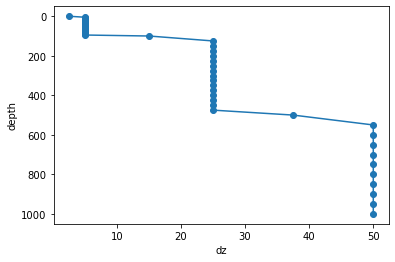

In [188]:
ds.dz.plot(y='depth', yincrease=False, marker='o');

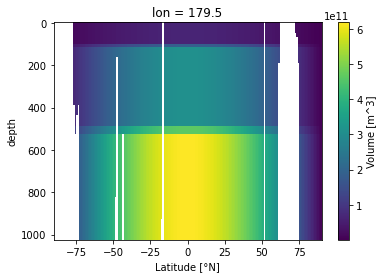

In [189]:
ds.volume.sel(lon=179.5).plot(yincrease=False);

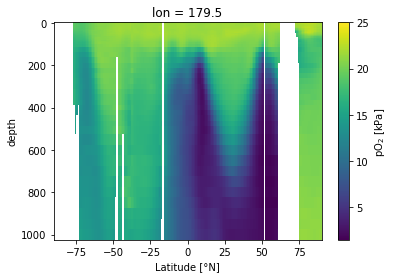

In [190]:
ds.pO2.sel(lon=179.5).plot(yincrease=False, vmax=25);

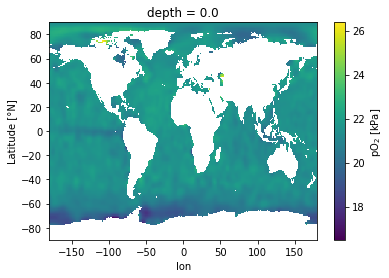

In [191]:
ds.pO2.sel(depth=0.0).plot();

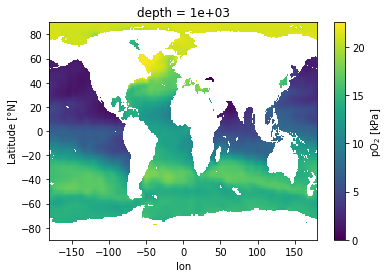

In [192]:
ds.pO2.sel(depth=1000.0).plot();

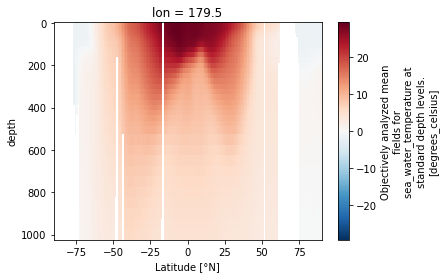

In [193]:
ds.t_an.sel(lon=179.5).plot(yincrease=False);

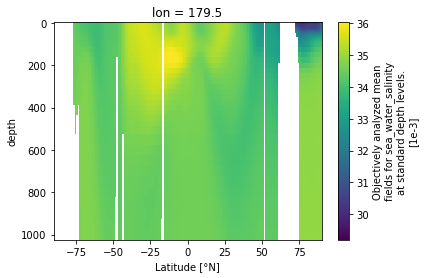

In [194]:
ds.s_an.sel(lon=179.5).plot(yincrease=False);

## Load trait space data

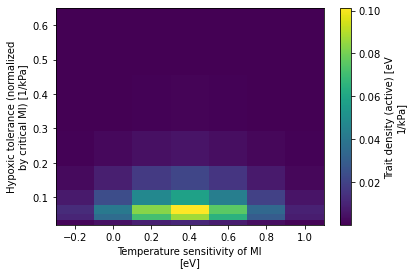

In [195]:
curator = util.curator_local_assets()
cat = curator.open_catalog()
ds_trait_space = cat['trait-space'].to_dask().load()

ds_trait_space.trait_spc_active.plot();

## Volume of viable habitat in trait-space

In [196]:
dso_vol = xr.Dataset()

for v in ['trait_spc_active', 'trait_spc_resting']:
    trait_space = ds_trait_space[v]
    metabolic_baseline = trait_space.attrs['metabolic_baseline']
    hypoxic_tol, temp_sens = trait_space.dims

    vol = xr.full_like(trait_space, fill_value=0.0)

    for i, A_parm in enumerate(trait_space[hypoxic_tol].values):
        for j, Eo in enumerate(trait_space[temp_sens].values):

            Phi = mi.Phi(ds.pO2, ds.t_an, Ac=A_parm, Eo=Eo, dEodT=mi.dEodT_bar)
            viable_trait_mask = xr.where(Phi > 1, 1.0, 0.0)

            vol[i, j] += (ds.volume * viable_trait_mask).sum(['depth', 'lat', 'lon'])

    vol_percent = 100.0 * vol / ds.volume.sum()
    vol_percent.attrs['long_name'] = 'Ocean volume'
    vol_percent.attrs['units'] = '%'

    vol *= 1e-6  # convert to 10^6 m^3
    vol.attrs['units'] = '10$^6$ m$^3$'

    name = f'vol_habitat_{metabolic_baseline}'
    dso_vol[name] = vol
    dso_vol[f'{name}_percent'] = vol_percent

dso_vol

<xarray.Dataset>
Dimensions:                      (Ac: 8, Eo: 7, Ao: 8)
Coordinates:
  * Ac                           (Ac) float64 0.0258 0.0399 ... 0.3568 0.5528
  * Eo                           (Eo) float64 -0.2 -0.0 0.2 0.4 0.6 0.8 1.0
  * Ao                           (Ao) float64 0.0613 0.0962 ... 0.9114 1.429
Data variables:
    vol_habitat_active           (Ac, Eo) float64 0.0 0.0 ... 3.312e+11
    vol_habitat_active_percent   (Ac, Eo) float64 0.0 0.0 0.0 ... 98.19 98.48
    vol_habitat_resting          (Ao, Eo) float64 5.835e+10 ... 3.356e+11
    vol_habitat_resting_percent  (Ao, Eo) float64 17.35 18.38 ... 99.74 99.78

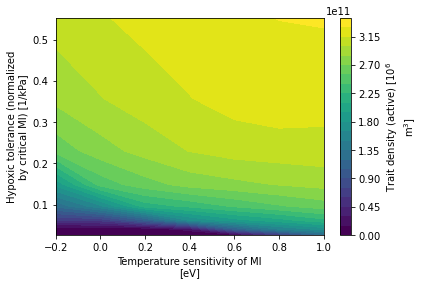

In [197]:
dso_vol.vol_habitat_active.plot.contourf(levels=30);

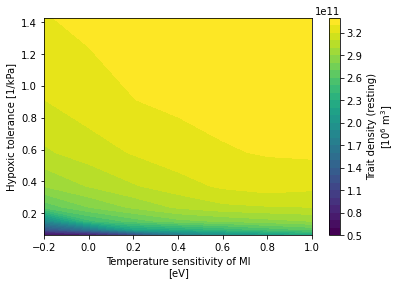

In [198]:
dso_vol.vol_habitat_resting.plot.contourf(levels=30);

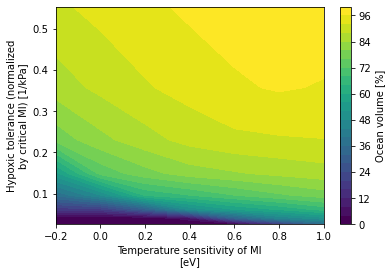

In [199]:
dso_vol.vol_habitat_active_percent.plot.contourf(levels=30);

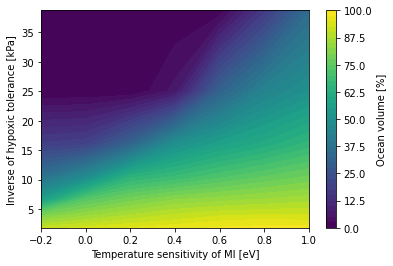

In [200]:
plt.contourf(
    dso_vol.vol_habitat_active_percent.Eo,
    1 / dso_vol.vol_habitat_active_percent.Ac,
    dso_vol.vol_habitat_active_percent,
    levels=np.arange(0, 102.5, 2.5),
)
cb = plt.colorbar()
plt.xlabel(util.attrs_label(dso_vol.Eo.attrs))

inv_attrs = dict(**dso_vol.Ac.attrs)
inv_attrs['long_name'] = 'Inverse of hypoxic tolerance'
inv_attrs['units'] = 'kPa'
plt.ylabel(util.attrs_label(inv_attrs))
cb.ax.set_ylabel(util.attrs_label(vol_percent.attrs));

## Examine trait frequency as a function of latitude

In [201]:
# construct an ATmax distribution with pre-defined bins
ATmax_bin_edge = np.arange(10, 64, 3)
ATmax_bin_c = np.vstack((ATmax_bin_edge[:-1], ATmax_bin_edge[1:])).mean(axis=0)
ATmax_bins = xr.DataArray(
    ATmax_bin_c,
    dims=('ATmax'),
    coords={'ATmax': ATmax_bin_c},
)
lat_var = xr.full_like(ds.pO2.isel(lon=0, depth=0, drop=True), fill_value=0.0)

dsets = {}
for v in ['trait_spc_resting', 'trait_spc_active']:

    # get trait space vars
    trait_space = ds_trait_space[v]
    metabolic_baseline = trait_space.attrs['metabolic_baseline']
    ATmax = ds_trait_space[f'ATmax_{metabolic_baseline}']
    hypoxic_tol, temp_sens = trait_space.dims

    # initialize trait distributions
    dso = xr.Dataset()
    dso['ATmax_dist'] = ATmax_bins * lat_var
    dso[f'{hypoxic_tol}_dist'] = trait_space[hypoxic_tol] * lat_var
    dso[f'{temp_sens}_dist'] = trait_space[temp_sens] * lat_var

    # loop over trait space and lat bands, sum trait frequency
    for i, A_parm in enumerate(trait_space[hypoxic_tol].values):
        for j, Eo in enumerate(trait_space[temp_sens].values):

            if np.isnan(ATmax[i, j]):
                continue

            # compute metabolic index
            Phi = mi.Phi(ds.pO2, ds.t_an, A_parm, Eo, dEodT=mi.dEodT_bar)
            trait_wgt = xr.where(Phi > 1, trait_space[i, j], 0.0)

            # loop over latitude and accumulate the frequency
            ndx_bin = np.searchsorted(ATmax_bin_edge, ATmax[i, j], side='left')
            for j_lat in range(ds.sizes['lat']):
                freq_j = (trait_wgt.isel(lat=j_lat) * ds.volume.isel(lat=j_lat)).sum()
                dso['ATmax_dist'][ndx_bin, j_lat] += freq_j
                dso[f'{hypoxic_tol}_dist'][i, j_lat] += freq_j
                dso[f'{temp_sens}_dist'][j, j_lat] += freq_j

    # normalize so integral is 1.0
    for key in dso.data_vars:
        dso[key] /= dso[key].sum()

    dsets[v] = dso

dsets

{'trait_spc_resting': <xarray.Dataset>
 Dimensions:     (ATmax: 17, lat: 180, Ao: 8, Eo: 7)
 Coordinates:
   * ATmax       (ATmax) float64 11.5 14.5 17.5 20.5 23.5 ... 50.5 53.5 56.5 59.5
   * lat         (lat) float32 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
   * Ao          (Ao) float64 0.0613 0.0962 0.1508 0.2364 ... 0.5813 0.9114 1.429
   * Eo          (Eo) float64 -0.2 -0.0 0.2 0.4 0.6 0.8 1.0
 Data variables:
     ATmax_dist  (ATmax, lat) float64 0.0 0.0 0.0 ... 1.777e-08 5.922e-09
     Ao_dist     (Ao, lat) float64 0.0 0.0 0.0 ... 8.522e-07 5.115e-07 1.705e-07
     Eo_dist     (Eo, lat) float64 0.0 0.0 0.0 ... 1.989e-05 1.194e-05 3.98e-06,
 'trait_spc_active': <xarray.Dataset>
 Dimensions:     (ATmax: 17, lat: 180, Ac: 8, Eo: 7)
 Coordinates:
   * ATmax       (ATmax) float64 11.5 14.5 17.5 20.5 23.5 ... 50.5 53.5 56.5 59.5
   * lat         (lat) float32 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
   * Ac          (Ac) float64 0.0258 0.0399 0.0619 ... 0.2303 0.3568 0.5

'ATmax'

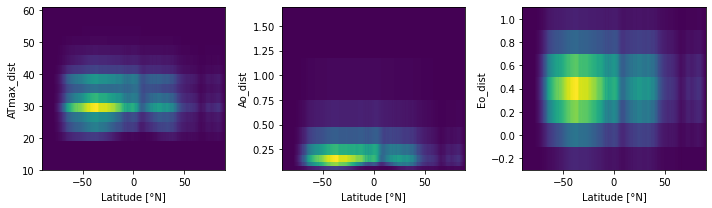

In [219]:
fig, axs = plt.subplots(1, 3, figsize=(10, 3), squeeze=False)

dso = dsets['trait_spc_resting']

for j, v in enumerate(['ATmax_dist', 'Ao_dist', 'Eo_dist']):
    ax = axs[0, j]
    coord = dso[v].dims[0]
    ax.pcolormesh(dso[v].lat, dso[v][coord], dso[v])
    ax.set_xlabel(util.attrs_label(dso.lat))
    ax.set_ylabel(util.attrs_label(dso[v]))

plt.tight_layout();

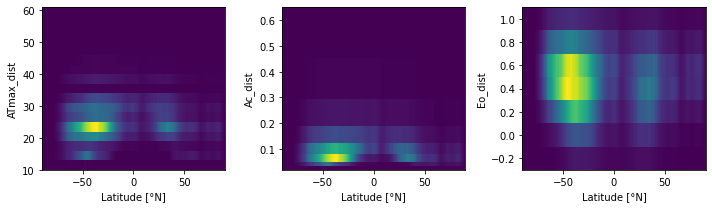

In [220]:
fig, axs = plt.subplots(1, 3, figsize=(10, 3), squeeze=False)

dso = dsets['trait_spc_active']

for j, v in enumerate(['ATmax_dist', 'Ac_dist', 'Eo_dist']):
    ax = axs[0, j]
    coord = dso[v].dims[0]
    ax.pcolormesh(dso[v].lat, dso[v][coord], dso[v])
    ax.set_xlabel(util.attrs_label(dso.lat))
    ax.set_ylabel(util.attrs_label(dso[v]))

plt.tight_layout();